In [ ]:
# jalankan jika buka dengan google colab
!pip install scikit-learn-extra
!pip install -U yellowbrick
!pip install pyclustering

In [1]:
import pandas as pd
import numpy as np

# save model
import os
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from pyclustering.cluster.xmeans import xmeans as XMeans
import time

from sklearn import metrics

# Load Cleaned Data

In [2]:
data_path = 'https://raw.githubusercontent.com/zeerafle/text-mining-clustering/master/data/clean_tweets.tsv'
data = pd.read_csv(data_path, sep='\t')
data.head()

,Unnamed: 0,Unnamed: 0.1,id_str,from_user,text,created_at,time,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,user_location,status_url,entities_str
0,0,0,1417635429579247617,Kosasih0706,lama tolak vaksin abai dulu,Tue Jul 20 23:59:59 +0000 2021,21/07/2021 00:59:59,NaN,NaN,1.416723955424002e+18,H4CKN3T_,9.343577e+17,1.417449e+18,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1313265976...,68.0,159.0,NaN,http://twitter.com/Kosasih0706/statuses/141763...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
1,1,1,1417635417269051392,frhikma,bandara soeta sedia layan vaksin bagaimana pro...,Tue Jul 20 23:59:56 +0000 2021,21/07/2021 00:59:56,NaN,NaN,994248960.0,frhikma,9.942490e+08,1.417634e+18,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1415948130...,376.0,317.0,"Tangerang, Indonesia",http://twitter.com/frhikma/statuses/1417635417...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[]..."
2,2,2,1417635413716389889,dynayum,allah selamat hoax baru vaksin rubah dna buat ...,Tue Jul 20 23:59:55 +0000 2021,21/07/2021 00:59:55,NaN,NaN,NaN,NaN,5.579809e+07,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/1415156494...,503.0,313.0,NaN,http://twitter.com/dynayum/statuses/1417635413...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
3,3,3,1417635409480216580,estywukak,bantu ibu jawab iya ibu vaksin sinovac suntik ...,Tue Jul 20 23:59:54 +0000 2021,21/07/2021 00:59:54,NaN,NaN,NaN,NaN,2.994025e+08,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1399574428...,1639.0,3666.0,"Nusa Tenggara Timur, Indonesia",http://twitter.com/estywukak/statuses/14176354...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[]..."
4,4,4,1417635391927033856,zaqhisyam,bibi positif covid sempat vaksin tahan vaksin ...,Tue Jul 20 23:59:50 +0000 2021,21/07/2021 00:59:50,NaN,NaN,NaN,NaN,1.187276e+08,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/1392746882...,422.0,457.0,"Kelang, Selangor",http://twitter.com/zaqhisyam/statuses/14176353...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."


In [3]:
data.text[121]

'cara sederhana saturasi oksigen rendah pasien covid sedang isolasi diri perlu tahu'

In [4]:
pd.to_datetime(data.drop(index=3628).created_at)

0      2021-07-20 23:59:59+00:00
1      2021-07-20 23:59:56+00:00
2      2021-07-20 23:59:55+00:00
3      2021-07-20 23:59:54+00:00
4      2021-07-20 23:59:50+00:00
                  ...           
8780   2021-07-27 08:41:02+00:00
8781   2021-07-27 08:41:00+00:00
8782   2021-07-27 08:41:00+00:00
8783   2021-07-27 08:40:59+00:00
8784   2021-07-27 08:40:58+00:00
Name: created_at, Length: 8784, dtype: datetime64[ns, UTC]

In [5]:
len(data)

8785

Ambil data yang kalimatnya lebih dari 2 kata

In [6]:
word_count = pd.Series(list(map(lambda x: len(str(x).split(" ")), data.text)))

word_count.describe()

count    8785.000000
mean       13.573591
std         8.377089
min         1.000000
25%         7.000000
50%        12.000000
75%        20.000000
max        55.000000
dtype: float64

In [7]:
data = data.loc[word_count > 2]
len(data)

8537

# Term Frequency - Inverse Document Frequency

TF (*Term Frequency*) adalah frekuensi dari kemunculan sebuah istilah dalam dokumen yang bersangkutan. Semakin besar jumlah kemunculan suatu term (TF tinggi) dalam dokumen, semakin besar pula bobotnya atau akan memberikan nilai keseuaian yang semakin besar. Berikut rumusnya:

$$
tf_{i,j} = \frac{n_{i,j}}{\sum_{k}n_{i,j}}
$$

Semerntara itu IDF merupakan sebuah perhitungan dari bagaimana term didistribusikan secara luas pada koleksi dokumen yang bersangkutan. IDF menunjukkan hubungan ketersediaan sebuah istilah dalam seluruh dekomuen. Semakin sedikit jumlah dokumen yang mengandung term yang dimaksud, maka nilai IDF semakin besar. IDF dihitung dengan:

$$
idf(w) = log(\frac{N}{df_{t}})
$$

Dengan mengombinasikan dua persamaan diatas kita dapat menemukan kata yang penting dalam dokumen (tweet). Rumus TF-IDF score adalah:

$$
w_{i,j} = tf_{i,j} * log(\frac{N}{df_{t}})
$$

---
**Referensi**
- [Text Mining dengan K-Means Clustering pada Tema LGBT dalam Arsip Tweet Masyarakat Kota Bandung](https://core.ac.uk/download/pdf/235583628.pdf)

In [8]:
# Untuk mengaplikasikan tf-idf, inputnya harus berupa list of tweet
tweets = data.text.to_list()
tweets[112:119]

['halo huan ying guan ling kenal julya chatime staff jababeka mau kasih tau kalau chatime banyak promo tau nya mulai promonya nampilin kartu vaksin nya dapet minum harga murah murah',
 'saran semua ppv lihat benar minta vaksinator hindar human error tipu moga jkjav lindung sehat atur sop percaya masyarakat program vaksinasi',
 'lebih satu juta lebih populasi terima dosis tunggal jumlah hampir satu juta lebih populasi dosis lengkap vaksinasi cara keluar pandemi cara konsisten praktik tindak sehat masyarakat',
 'cara sederhana saturasi oksigen rendah pasien covid sedang isolasi diri perlu tahu',
 'q list lho sdhan by link vaksin nusantara',
 'talok e dry hit the vaksin',
 'hari vaksin kemarin badan turun sakit tenggorok tahan benar badan cepat lelah minum vitamin obat flu makin hari suara mulai serak batuk alhamdulillah makin hari makin baik']

In [9]:
tfidf = TfidfVectorizer(max_features=None,
                       max_df=0.2,
                       min_df=5,
                       ngram_range=(1,2))
features = tfidf.fit_transform(tweets)

print(features.shape)

(8537, 4714)


## Term Document Matrix

In [11]:
tdm_tfidf = pd.DataFrame(features.toarray(), index=['tweet ' + str(i+1) for i in range(len(data))])
tdm_tfidf.columns = tfidf.get_feature_names()
tdm_tfidf.head()

,aaa,abai,abang,abdi,acara,acara vaksinasi,ad,adakan,adha,adik,...,yo,yogyakarta,you,your,youtube,yuk,zaman,zeneca,zona,zoo
tweet 1,0.0,0.564896,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.227944,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 4,0.0,0.000000,0.189054,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 5,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
tdm_tfidf.sum(axis=1).sort_values()

tweet 5318    0.000000
tweet 433     0.000000
tweet 7474    0.000000
tweet 2970    0.000000
tweet 4863    0.000000
                ...   
tweet 4948    6.447910
tweet 5680    6.514599
tweet 4996    6.524810
tweet 5431    6.809556
tweet 7234    6.871570
Length: 8537, dtype: float64

### Visualisasi TF

In [13]:
tf = CountVectorizer(max_features=None,
                    max_df=0.2,
                    min_df=5)
vects = tf.fit_transform(data.text)

In [14]:
td = pd.DataFrame(vects.todense())
td

,0,1,2,3,4,5,6,7,8,9,...,2304,2305,2306,2307,2308,2309,2310,2311,2312,2313
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8532,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8533,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
td.columns = tf.get_feature_names() # namain judul kolom jadi setiap kata
tdm_tf = td.T # transpose
# namain judul kolom (setelah di transpose) menjadi
# tweet 1, tweet 2, dst, sepanjang banyaknya tweet
tdm_tf.columns = ['tweet ' + str(i+1) for i in range(len(td))]
tdm_tf['total_count'] = tdm_tf.sum(axis=1) # total kata

In [16]:
tdm_tf.head()

,tweet 1,tweet 2,tweet 3,tweet 4,tweet 5,tweet 6,tweet 7,tweet 8,tweet 9,tweet 10,...,tweet 8529,tweet 8530,tweet 8531,tweet 8532,tweet 8533,tweet 8534,tweet 8535,tweet 8536,tweet 8537,total_count
aaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
abai,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
abang,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
abdi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
acara,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32


In [17]:
# top 50 kata
word_freq = tdm_tf.sort_values(by='total_count', ascending=False)
word_freq.head()

,tweet 1,tweet 2,tweet 3,tweet 4,tweet 5,tweet 6,tweet 7,tweet 8,tweet 9,tweet 10,...,tweet 8529,tweet 8530,tweet 8531,tweet 8532,tweet 8533,tweet 8534,tweet 8535,tweet 8536,tweet 8537,total_count
covid,0,0,0,0,1,0,0,2,0,0,...,0,2,0,0,0,1,0,0,0,1429
orang,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1355
hari,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,0,0,0,972
mau,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,902
jadi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,878


<AxesSubplot:title={'center':'Top 50 Kata'}>

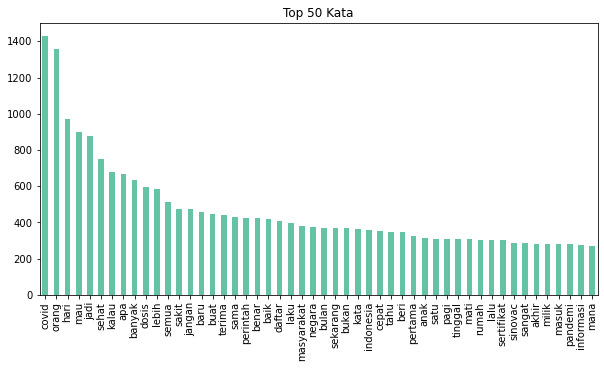

In [18]:
word_freq.iloc[:50,-1].plot(kind="bar",
                           figsize=(10,5),
                           colormap='Set2',
                           title="Top 50 Kata")

<function matplotlib.pyplot.show(close=None, block=None)>

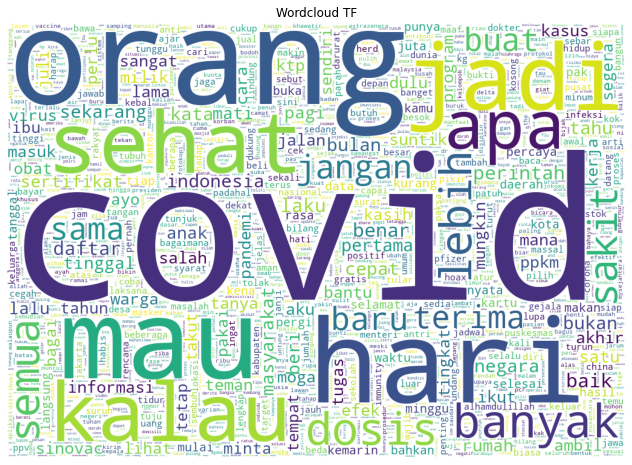

In [19]:
# visualisasi wordcloud
wordcloud = WordCloud(background_color='white', max_words=2000,
                     width=1024, height=720)
plt.figure(figsize=(20,8))
plt.title('Wordcloud TF')
plt.imshow(wordcloud.generate_from_frequencies(word_freq.iloc[:,-1].to_dict()))
plt.axis('off')
plt.show

# Clustering

## K-Means Clustering

### Training

Sekaligus hitung waktu trainingnya untuk digunakan pada bagian evaluasi

In [12]:
K = 10 #jumlah cluster
kmeans = KMeans(n_clusters=K, max_iter=100,
                random_state=1, algorithm='full',
                init='random')
t0 = time.time()
kmeans.fit(features)
kmeans_exec = time.time() - t0

In [14]:
# simpan model supaya tidak perlu training lagi
os.makedirs(os.path.dirname("dumps/trained_models/"), exist_ok=True)

with open('dumps/trained_models/kmeans.model', 'wb') as f:
    pickle.dump(kmeans, f)
    f.close()

In [ ]:
# jalankan jika model sudah pernah disimpan
with open('dumps/trained_models/kmeans.model', 'rb') as f:
    kmeans = pickle.load(f)

### Labelling

In [15]:
top_10_features = []
current_cluster = []
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()

for i in range(K):
    for ind in order_centroids[i, :10]:
        current_cluster.append(terms[ind])
    top_10_features.append(current_cluster)
    current_cluster = []

In [16]:
topic_table_kmeans = pd.DataFrame({"terms": top_10_features, "cluster": range(K)})
topic_table_kmeans.terms = topic_table_kmeans.terms.apply(lambda x : ", ". join(x))
topic_table_kmeans

,terms,cluster
0,"covid, vaksin covid, vaksinasi covid, kg, covi...",0
1,"bukan, vaksin bukan, bukan vaksin, jadi, arti,...",1
2,"ayo, ayo vaksin, ayo vaksinasi, vaksin ayo, ja...",2
3,"orang, banyak, orang orang, banyak orang, oran...",3
4,"hari, hari vaksin, vaksin hari, hari vaksinasi...",4
5,"daftar, pagi, kasih, terima, terima kasih, daf...",5
6,"dosis, pertama, dosis vaksin, vaksin pertama, ...",6
7,"mau, mau vaksin, kalau, kalau mau, hari, dulu,...",7
8,"sehat, patuh, tenaga, tenaga sehat, protokol, ...",8
9,"jadi, apa, kalau, jangan, benar, sertifikat, s...",9


In [ ]:
# jalankan jika ingin disimpan
topic_table_kmeans.to_csv('top 10 fitur per cluster kmeans.tsv', sep='\t', index=False)

### Plotting Cluster

In [17]:
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(features.toarray())

In [18]:
centroid_plot = pca.fit_transform(kmeans.cluster_centers_)
centroid_plot

array([[ 0.00848711, -0.02278786],
       [-0.01327975, -0.01253617],
       [ 0.27034983,  0.07558463],
       [-0.01178921, -0.01128693],
       [-0.08535421, -0.1476749 ],
       [-0.01945134, -0.02184978],
       [-0.01797599, -0.07086465],
       [-0.14874582,  0.23277039],
       [ 0.02193282, -0.01185437],
       [-0.00417344, -0.00950037]])

Text(0.5, 1.0, 'KMeans clustering')

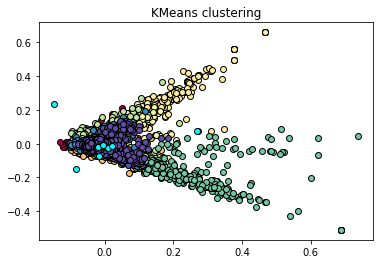

In [19]:
# visualisasi scatter plot
labels = kmeans.labels_
unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = scatter_plot_points[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    centroid_plot[:, 0],
    centroid_plot[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMeans clustering")

### Wordcloud per cluster

In [20]:
result_kmeans = pd.DataFrame({"tweet": tweets, "cluster": kmeans.labels_})

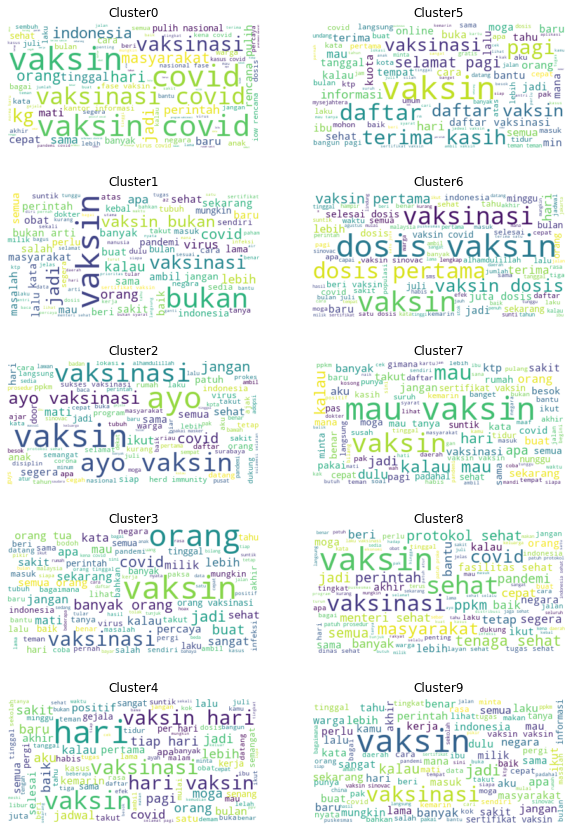

In [21]:
fig, ax = plt.subplots(5, 2, figsize=(10,15))
for i in range(K):
    idx = i % 5
    idy = i // 5
    
    s = result_kmeans[result_kmeans.cluster == i]
    text = s['tweet'].str.cat(sep=' ')
    text = text.lower()
    text = ' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100,
                         background_color='white').generate(text)
    
    ax[idx, idy].imshow(wordcloud, interpolation='bilinear')
    ax[idx, idy].axis('off')
    ax[idx, idy].set_title("Cluster" + str(i))

In [22]:
print('Jumlah tweet tiap cluster')
result_kmeans.cluster.value_counts()

Jumlah tweet tiap cluster


9    4482
0     780
3     734
8     466
5     444
6     444
7     389
4     372
1     275
2     151
Name: cluster, dtype: int64

## K-Medoids Clustering

### Training

In [23]:
K = 10
kmedoids = KMedoids(n_clusters=K, max_iter=100,
                    random_state=1, init='random',
                    method='pam')
t0 = time.time()
kmedoids.fit(features)
kmedoids_exec = time.time() - t0

In [24]:
# save model
os.makedirs(os.path.dirname("dumps/trained_models/"), exist_ok=True)

with open('dumps/trained_models/kmedoids.model', 'wb') as f:
    pickle.dump(kmedoids, f)
    f.close()

In [ ]:
# jalankan jika sudah menyimpan model
with open("dumps/trained_models/kmedoids.model", 'rb') as f:
    kmedoids = pickle.load(f)

### Labelling

In [25]:
top_10_features = []
current_cluster = []
order_centroids = kmedoids.cluster_centers_.toarray().argsort()[:, ::-1]
terms = tfidf.get_feature_names()

for i in range(k):
    for ind in order_centroids[i, :10]:
        current_cluster.append(terms[ind])
    top_10_features.append(current_cluster)
    current_cluster = []

In [26]:
topic_table_kmedoids = pd.DataFrame({"terms": top_10_features, "cluster": range(k)})
topic_table_kmedoids.terms = topic_table_kmedoids.terms.apply(lambda x : ", ". join(x))
topic_table_kmedoids

,terms,cluster
0,"zoo, jejak, jasa, jatah, jatah vaksin, jatim, ...",0
1,"hari vaksin, hari, jaya, jauh, jasa, jatah, ja...",1
2,"hari vaksinasi, hari, jasa, jatah, jatah vaksi...",2
3,"kg, besut, darurat lokasi, vaksin proklamasi, ...",3
4,"lupa vaksin, jangan lupa, lupa, jangan, zoo, j...",4
5,"mau vaksin, mau, zoo, jasa, jatah, jatah vaksi...",5
6,"semangat vaksin, semangat, jatuh sakit, jarum,...",6
7,"tanggal vaksin, tanggal, jatuh, jaring, jarum,...",7
8,"anti vaksin, anti, jarum suntik, jatah, jatah ...",8


In [ ]:
# jalankan jika ingin disimpan
topic_table_kmedoids.to_csv('top 10 fitur per cluster kmedoids.tsv', sep='\t', index=False)

### Plotting Cluster

In [27]:
scatter_plot_points = pca.fit_transform(features.toarray())
centroid_plot = pca.fit_transform(kmeans.cluster_centers_)

Text(0.5, 1.0, 'KMedoids clustering')

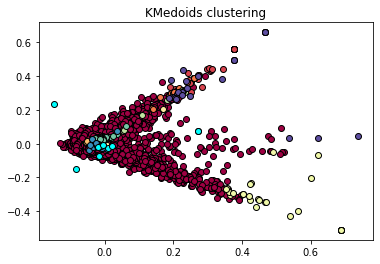

In [28]:
labels = kmedoids.labels_
unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = scatter_plot_points[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    centroid_plot[:, 0],
    centroid_plot[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering")

### Wordcloud per cluster

In [29]:
result_kmedoids = pd.DataFrame({"tweet": tweets, "cluster": kmedoids.labels_})

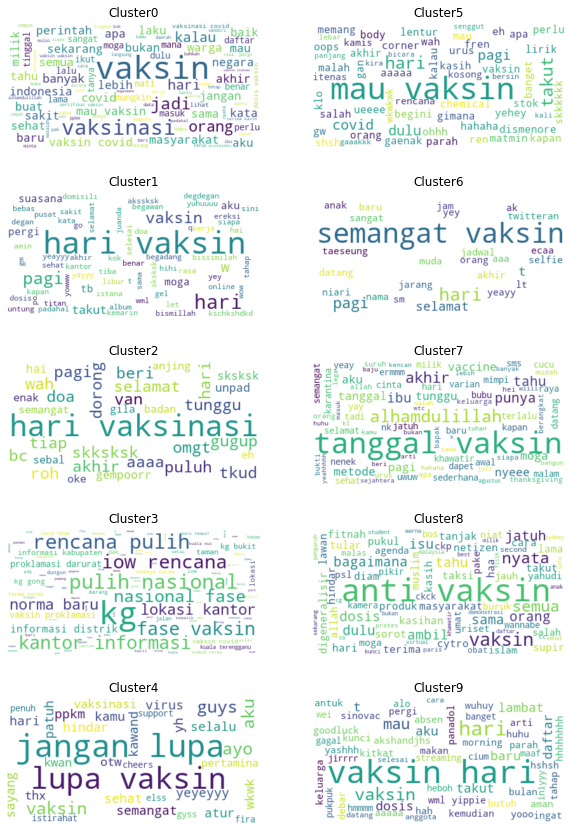

In [30]:
fig, ax = plt.subplots(5, 2, figsize=(10,15))
for i in range(10):
    idx = i % 5
    idy = i // 5
    
    s = result_kmedoids[result_kmedoids.cluster == i]
    text = s['tweet'].str.cat(sep=' ')
    text = text.lower()
    text = ' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100,
                         background_color='white').generate(text)
    
    ax[idx, idy].imshow(wordcloud, interpolation='bilinear')
    ax[idx, idy].axis('off')
    ax[idx, idy].set_title("Cluster" + str(i))

In [31]:
print('Jumlah tweet tiap cluster')
result_kmedoids.cluster.value_counts()

Jumlah tweet tiap cluster


0    8319
1      36
3      32
7      29
9      27
5      27
8      20
2      18
4      15
6      14
Name: cluster, dtype: int64

## Accelerated K-Means

### Training

In [32]:
K = 10
acc_kmeans = KMeans(n_clusters=K,
                    max_iter=100,
                    random_state=1,
                    algorithm='elkan',
                    init='random')
t0 = time.time()
acc_kmeans.fit(features)
acc_kmeans_exec = time.time() - t0

In [33]:
# save model
os.makedirs(os.path.dirname("dumps/trained_models/"), exist_ok=True)

with open('dumps/trained_models/acc_kmeans.model', 'wb') as f:
    pickle.dump(acc_kmeans, f)
    f.close()

In [23]:
# jalankan jika sudah menyimpan model
with open("dumps/trained_models/acc_kmeans.model", 'rb') as f:
    acc_kmeans = pickle.load(f)

### Labelling

In [34]:
top_10_features = []
current_cluster = []
order_centroids = acc_kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()

for i in range(K):
    for ind in order_centroids[i, :10]:
        current_cluster.append(terms[ind])
    top_10_features.append(current_cluster)
    current_cluster = []

In [35]:
topic_table_acc_kmeans = pd.DataFrame({"terms": top_10_features, "cluster": range(K)})
topic_table_acc_kmeans.terms = topic_table_acc_kmeans.terms.apply(lambda x : ", ". join(x))
topic_table_acc_kmeans

,terms,cluster
0,"covid, vaksin covid, vaksinasi covid, kg, covi...",0
1,"sehat, tenaga, tenaga sehat, protokol, protoko...",1
2,"ayo, ayo vaksin, ayo vaksinasi, vaksin ayo, ja...",2
3,"orang, banyak, banyak orang, orang orang, oran...",3
4,"hari, hari vaksin, vaksin hari, hari vaksinasi...",4
5,"daftar, pagi, kasih, terima kasih, terima, daf...",5
6,"dosis, pertama, dosis vaksin, vaksin pertama, ...",6
7,"mau, mau vaksin, kalau, kalau mau, hari, dulu,...",7
8,"semua, semua orang, orang, semua vaksin, vaksi...",8
9,"jadi, apa, kalau, benar, jangan, sertifikat, l...",9


In [ ]:
# jalankan jika ingin disimpan
topic_table_acc_kmeans.to_csv('top 10 fitur per cluster acc kmeans.tsv', sep='\t', index=False)

### Plotting Cluster

In [36]:
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(features.toarray())
centroid_plot = pca.fit_transform(acc_kmeans.cluster_centers_)

Text(0.5, 1.0, 'Accelerated K-Means clustering')

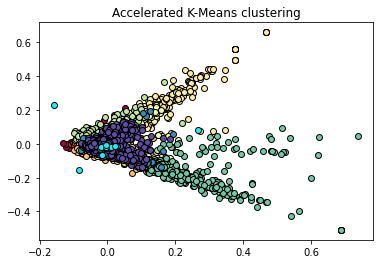

In [37]:
# visualisasi scatter plot
labels = acc_kmeans.labels_
unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = scatter_plot_points[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    centroid_plot[:, 0],
    centroid_plot[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("Accelerated K-Means clustering")

### Wordcloud per cluster

In [38]:
result_acc_kmeans = pd.DataFrame({"tweet": tweets, "cluster": kmeans.labels_})

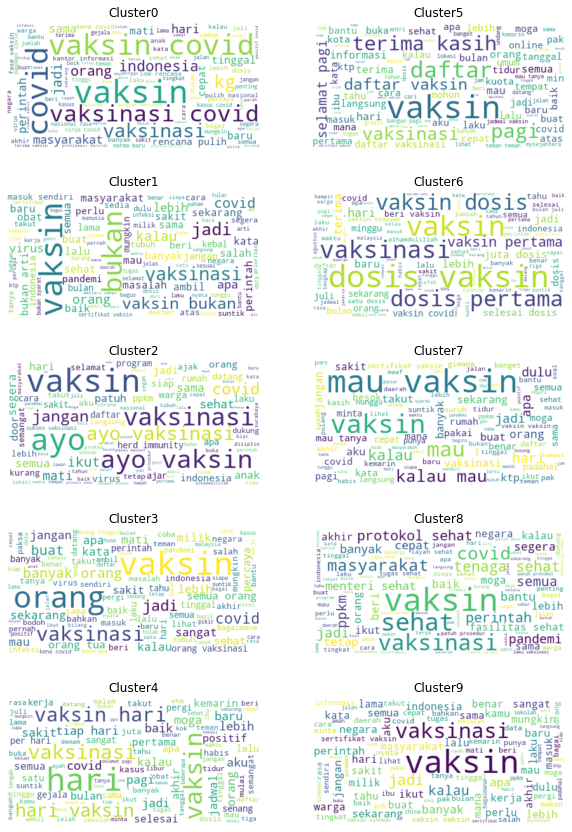

In [39]:
fig, ax = plt.subplots(5, 2, figsize=(10,15))
for i in range(K):
    idx = i % 5
    idy = i // 5
    
    s = result_acc_kmeans[result_acc_kmeans.cluster == i]
    text = s['tweet'].str.cat(sep=' ')
    text = text.lower()
    text = ' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100,
                         background_color='white').generate(text)
    
    ax[idx, idy].imshow(wordcloud, interpolation='bilinear')
    ax[idx, idy].axis('off')
    ax[idx, idy].set_title("Cluster" + str(i))

In [40]:
print('Jumlah tweet tiap cluster')
result_acc_kmeans.cluster.value_counts()

Jumlah tweet tiap cluster


9    4482
0     780
3     734
8     466
5     444
6     444
7     389
4     372
1     275
2     151
Name: cluster, dtype: int64

## X-Means

### Training

In [55]:
from pyclustering.cluster.center_initializer import random_center_initializer
K = 10

t0 = time.time()
initial_centers = random_center_initializer(features.toarray(), K).initialize()
xmeans = XMeans(features.todense(), initial_centers, K)
xmeans.process()
xmeans_exec = time.time() - t0

In [57]:
# save model
os.makedirs(os.path.dirname("dumps/trained_models/"), exist_ok=True)

with open('dumps/trained_models/xmeans.model', 'wb') as f:
    pickle.dump(xmeans, f)
    f.close()

In [13]:
# jalankan jika sudah menyimpan model
with open("dumps/trained_models/xmeans.model", 'rb') as f:
    xmeans = pickle.load(f)

### Labelling

In [58]:
top_10_features = []
current_cluster = []
order_centroids = np.array(xmeans.get_centers()).argsort()[:, ::-1]
terms = tfidf.get_feature_names()

for i in range(K):
    for ind in order_centroids[i, :10]:
        current_cluster.append(terms[ind])
    top_10_features.append(current_cluster)
    current_cluster = []

In [59]:
topic_table_xmeans = pd.DataFrame({"terms": top_10_features, "cluster": range(K)})
topic_table_xmeans.terms = topic_table_xmeans.terms.apply(lambda x : ", ". join(x))
topic_table_xmeans

,terms,cluster
0,"covid, vaksin covid, sehat, vaksinasi covid, m...",0
1,"hari, hari vaksin, vaksin hari, hari vaksinasi...",1
2,"orang, sakit, banyak, orang orang, banyak oran...",2
3,"buat, indonesia, buat vaksin, kasus, vaksin bu...",3
4,"mau, apa, mau vaksin, kalau, pagi, sertifikat,...",4
5,"negara, tugas, sehat, tingkat, ktp, perlu, ban...",5
6,"daftar, lebih, daftar vaksin, baik, lebih baik...",6
7,"dosis, dosis vaksin, vaksin dosis, dosis perta...",7
8,"jadi, sangat, tahu, vaksin jadi, mau, apa, ben...",8
9,"sekali, sama sekali, sama, sekali vaksin, saya...",9


In [ ]:
# jalankan jika ingin disimpan
topic_table_xmeans.to_csv('top 10 fitur clustering xmeans.tsv', sep='\t', index=False)

### Plotting Cluster

In [60]:
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(features.toarray())
centroid_plot = pca.fit_transform(xmeans.get_centers())

In [61]:
result_xmeans = pd.DataFrame(columns=['tweet', 'cluster'])

for cluster_num, cluster in enumerate(xmeans.get_clusters()):
    for tweet_index in cluster:
        result_xmeans = result_xmeans.append({'tweet': tweets[tweet_index], 'cluster': cluster_num}, ignore_index=True)

tweets_df = pd.DataFrame({'tweet': tweets})
result_xmeans = tweets_df.join(result_xmeans.set_index('tweet'), on='tweet')

Text(0.5, 1.0, 'X-Means clustering')

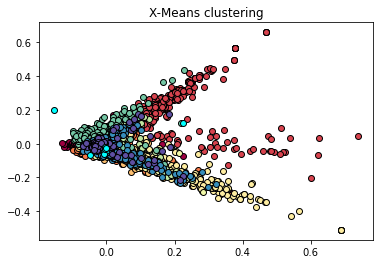

In [62]:
# visualisasi scatter plot
labels = result_xmeans.cluster.to_numpy()
unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = scatter_plot_points[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    centroid_plot[:, 0],
    centroid_plot[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("X-Means clustering")

### Wordcloud per cluster

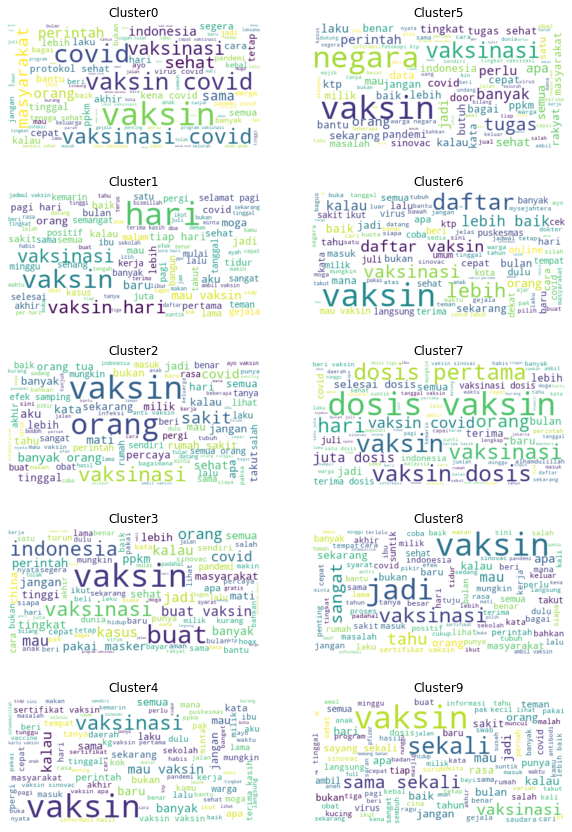

In [63]:
fig, ax = plt.subplots(5, 2, figsize=(10,15))
for i in range(K):
    idx = i % 5
    idy = i // 5
    
    s = result_xmeans[result_xmeans.cluster == i]
    text = s['tweet'].str.cat(sep=' ')
    text = text.lower()
    text = ' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100,
                         background_color='white').generate(text)
    
    ax[idx, idy].imshow(wordcloud, interpolation='bilinear')
    ax[idx, idy].axis('off')
    ax[idx, idy].set_title("Cluster" + str(i))

In [66]:
result_xmeans.cluster.value_counts()

4    3734
0     921
2     877
8     641
6     511
3     502
7     455
1     450
5     334
9     112
Name: cluster, dtype: int64

# Visualization

In [ ]:
def points_to_2d(n_components, data, title, show_plot=False):
    pca = PCA(n_components=n_components)
    scatter_plot_points = pca.fit_transform(data)
    if show_plot == True:
        plt.scatter(scatter_plot_points[:,0], scatter_plot_points[:,1])
        plt.title(title)
        plt.savefig(title + "/" + title + "0")
    
    return scatter_plot_points, pca

def plot_animation_frame(cluster_centers, labels, title, name, word_features):
    scatter_plot_points, pca = points_to_2d(2, word_features, title)

    # visualisasi scatter plot
    unique_labels = set(labels)
    colors = [
        plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
    ]
    for k, col in zip(unique_labels, colors):

        class_member_mask = labels == k

        xy = scatter_plot_points[class_member_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    centroid_plot = pca.fit_transform(cluster_centers)
    plt.plot(
        centroid_plot[:, 0],
        centroid_plot[:, 1],
        "x",
        markerfacecolor="black",
        markeredgecolor="k",
        markersize=9,
    )

    plt.title(title)
    plt.savefig(title + "/" + name, transparent=False)

In [ ]:
def run_clustering_animation(algorithm, word_features, n_iteration, k):
    _ = points_to_2d(2, word_features, title=algorithm, show_plot=True)
    if algorithm.lower() == "kmeans":
        kmeans = KMeans(n_clusters=k, max_iter=1,
                        random_state=1, algorithm='full',
                        init='random', n_init=1)
        kmeans.fit(features)
        
        counter = 1
        for i in range(n_iteration):
            filename = algorithm + str(counter)
            plot_animation_frame(kmeans.cluster_centers_, kmeans.labels_, algorithm, filename, word_features)
            plt.figure().clear()
            kmeans = KMeans(n_clusters=k, max_iter=1,
                            random_state=1, algorithm='full',
                            init=kmeans.cluster_centers_,
                            n_init=1)
            kmeans.fit(features)

            counter += 1

In [ ]:
run_clustering_animation("kmeans", features.toarray(), 200, 10)

# Evaluation

## Clustering Performance

In [67]:
kmeans_labels = kmeans.labels_
kmedoids_labels = kmedoids.labels_
acc_kmeans_labels = acc_kmeans.labels_
xmeans_labels = result_xmeans.cluster.to_numpy()

model_labels_list = [kmeans_labels, kmedoids_labels, acc_kmeans_labels, xmeans_labels]
model_names = ['K-Means', 'K-Medoids', 'Accelerated K-Means', 'X-Means']

In [68]:
def metric_table(metric, model_labels, index=model_names, tfidf_matrix=features):
    metric_scores = []
    
    for i in model_labels:
        metric_scores.append(metric(tfidf_matrix, i))
    
    return pd.DataFrame({metric.__name__: metric_scores},
                       index=index)

### Silhouette Index

In [69]:
si_table = metric_table(metrics.silhouette_score, model_labels_list)
si_table

,silhouette_score
K-Means,0.007688
K-Medoids,-0.006039
Accelerated K-Means,0.007474
X-Means,0.006103


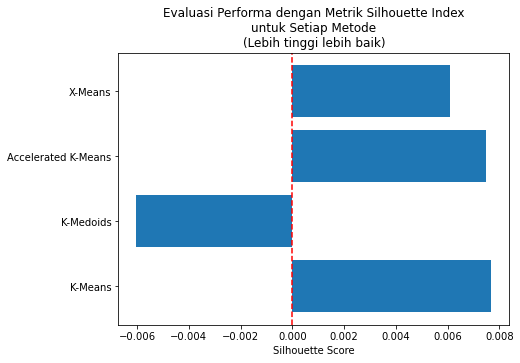

In [70]:
ig = plt.figure(figsize=(7,5))

plt.barh(range(len(si_table)), si_table.silhouette_score)
plt.yticks(range(len(si_table)), labels=model_names)
plt.axvline(x=0, color="red", linestyle="--")
plt.xlabel('Silhouette Score')
plt.title('Evaluasi Performa dengan Metrik Silhouette Index\nuntuk Setiap Metode\n(Lebih tinggi lebih baik)')

# fig.savefig('gambar/silhouette score.jpg', bbox_inches='tight', dpi=150)
plt.show()

### Davies-Bouldin Index

In [71]:
dbi_table = metric_table(metrics.davies_bouldin_score,
                         model_labels_list,
                         tfidf_matrix=features.toarray())
dbi_table

,davies_bouldin_score
K-Means,8.744402
K-Medoids,2.304506
Accelerated K-Means,8.812158
X-Means,10.530436


<AxesSubplot:title={'center':'Davies-Bouldin Index\n(lebih rendah lebih baik)'}>

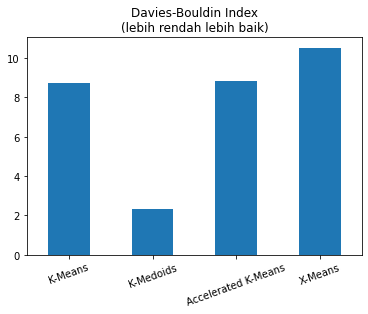

In [72]:
dbi_table.plot(kind='bar',
              legend=False,
              rot=20,
              title='Davies-Bouldin Index\n(lebih rendah lebih baik)')

### Calinski-Harabasz Index

In [73]:
chi_table = metric_table(metrics.calinski_harabasz_score,
                        model_labels_list,
                        tfidf_matrix=features.toarray())
chi_table

,calinski_harabasz_score
K-Means,22.810522
K-Medoids,12.960916
Accelerated K-Means,22.623188
X-Means,18.012541


<AxesSubplot:title={'center':'Calinski-Harabasz Index\n(lebih tinggi lebih baik)'}>

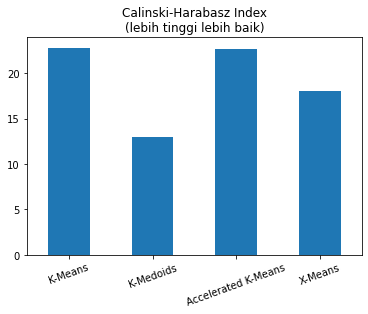

In [74]:
chi_table.plot(kind='bar',
              legend=False,
              rot=20,
              title='Calinski-Harabasz Index\n(lebih tinggi lebih baik)')

## Waktu Eksekusi

Semua menggunakan 10 cluster

In [75]:
pd.DataFrame({"Waktu eksekusi": [kmeans_exec, kmedoids_exec, acc_kmeans_exec, xmeans_exec]},
            index=["K-Means", "K-Medoids", "Accelerated K-Means", "X-Means"])

,Waktu eksekusi
K-Means,2.286584
K-Medoids,349.912048
Accelerated K-Means,15.033686
X-Means,22.066293
